In [1]:
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Step 1: Load data
# file_path = "user-wallet-transactions.json"
file_path = r"user-wallet-transactions.json"
with open(file_path, 'r') as f:
    data = json.load(f)
    df = pd.DataFrame(data)


In [3]:
# Step 2: Extract amount from actionData
def extract_amount(row):
    try:
        return float(row['actionData'].get('amount', 0)) / 1e18  # Normalize to ETH units
    except:
        return 0

df["amount"] = df.apply(extract_amount, axis=1)
df["datetime"] = pd.to_datetime(df["timestamp"], unit="s")


In [4]:
# Step 3: Feature engineering
def generate_wallet_features(df):
    grouped = df.groupby("userWallet")
    features = pd.DataFrame()
    features["total_transactions"] = grouped.size()
    features["deposit_count"] = grouped.apply(lambda x: (x["action"] == "deposit").sum())
    features["borrow_count"] = grouped.apply(lambda x: (x["action"] == "borrow").sum())
    features["repay_count"] = grouped.apply(lambda x: (x["action"] == "repay").sum())
    features["redeem_count"] = grouped.apply(lambda x: (x["action"] == "redeemunderlying").sum())
    features["liquidation_count"] = grouped.apply(lambda x: (x["action"] == "liquidationcall").sum())
    features["total_deposit_amount"] = grouped.apply(lambda x: x.loc[x["action"] == "deposit", "amount"].sum())
    features["total_borrow_amount"] = grouped.apply(lambda x: x.loc[x["action"] == "borrow", "amount"].sum())
    features["total_repay_amount"] = grouped.apply(lambda x: x.loc[x["action"] == "repay", "amount"].sum())
    features["active_days"] = grouped["datetime"].apply(lambda x: x.dt.date.nunique())
    features["last_active_days_ago"] = grouped["datetime"].apply(lambda x: (pd.Timestamp.now() - x.max()).days)
    return features.reset_index()

features_df = generate_wallet_features(df)

C:\Users\91886\AppData\Local\Temp\ipykernel_7280\1166028860.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  features["deposit_count"] = grouped.apply(lambda x: (x["action"] == "deposit").sum())
C:\Users\91886\AppData\Local\Temp\ipykernel_7280\1166028860.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  features["borrow_count"] = grouped.apply(lambda x: (x["action"] == "borrow").sum())
C:\Users\91886\A

In [5]:
# Step 4: Score labeling (credit score creation)
features_df["repay_to_borrow_ratio"] = features_df["total_repay_amount"] / (features_df["total_borrow_amount"] + 1e-6)
features_df.fillna(0, inplace=True)

# Heuristic credit score calculation
features_df["raw_score"] = (
    0.4 * np.log1p(features_df["total_deposit_amount"]) +
    0.3 * features_df["repay_to_borrow_ratio"].clip(0, 5) +
    0.2 * features_df["active_days"].clip(upper=30) -
    0.1 * features_df["liquidation_count"].clip(upper=5)
)

# Normalize score to 0–1000
scaler = MinMaxScaler(feature_range=(0, 1000))
features_df["credit_score"] = scaler.fit_transform(features_df[["raw_score"]])


In [6]:
# Step 5: Print some scores before training
print("\n🔍 Sample wallet credit scores (before training):")
print(features_df[["userWallet", "credit_score"]].head(10))


🔍 Sample wallet credit scores (before training):
                                   userWallet  credit_score
0  0x00000000001accfa9cef68cf5371a23025b6d4b6      7.564269
1  0x000000000051d07a4fb3bd10121a343d85818da6    166.281542
2  0x000000000096026fb41fc39f9875d164bd82e2dc     23.647049
3  0x0000000000e189dd664b9ab08a33c4839953852c    119.031826
4  0x0000000002032370b971dabd36d72f3e5a7bf1ee    834.250865
5  0x000000000a38444e0a6e37d3b630d7e855a7cb13    525.990981
6  0x000000003853fcedcd0355fec98ca3192833f00b     56.750934
7  0x000000003ce0cf2c037493b1dc087204bd7f713e    868.237113
8  0x000000007858e6f2668e1e06111cfa24403a5466     10.386107
9  0x00000001a0f57e850c9db68b4a9bc34677437c5c      7.564269


In [7]:
features_df.tail()

,userWallet,total_transactions,deposit_count,borrow_count,repay_count,redeem_count,liquidation_count,total_deposit_amount,total_borrow_amount,total_repay_amount,active_days,last_active_days_ago,repay_to_borrow_ratio,raw_score,credit_score
3492,0x06185db89f5c8ef5e5a0abc95c5cb69b54c33f30,1,1,0,0,0,0,9.800000e-17,0.000000e+00,0.000000e+00,1,1471,0.000000,0.200000,7.564269
3493,0x06189341e523a52ae10c4bd4a7774371fac1b249,7,4,1,0,2,0,9.664408e+00,1.250000e+00,0.000000e+00,1,1515,0.000000,1.146765,82.945378
3494,0x0618c450370822c5cb25ec143a3008230d8e2c12,5,1,0,0,4,0,1.410546e+01,0.000000e+00,0.000000e+00,1,1525,0.000000,1.286023,94.033047
3495,0x0618e615c8c9b5efc8c8eadc68be7182bdc455e2,22,13,2,2,5,0,1.725242e+03,1.200000e-09,2.001084e-10,11,1472,0.000200,5.181541,404.192973
3496,0x06192f889f17bf2aff238d08d8c26cbcfcc7b45a,183,53,48,36,46,0,9.858814e+04,3.192793e+05,1.123869e+05,37,1499,0.352002,10.705087,843.975978


In [8]:
# Step 6: Prepare data for model training
X = features_df.drop(columns=["userWallet", "raw_score", "credit_score"])
y = features_df["credit_score"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Step 7: Train ML model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [10]:
# Step 8: Evaluate model
y_pred = model.predict(X_test)

In [11]:
print("\n📊 Model Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R^2 Score:", r2_score(y_test, y_pred))


📊 Model Performance:
MAE: 3.984188294891045
MSE: 75.14804455511222
RMSE: 8.668797180411607
R^2 Score: 0.9986681857997624


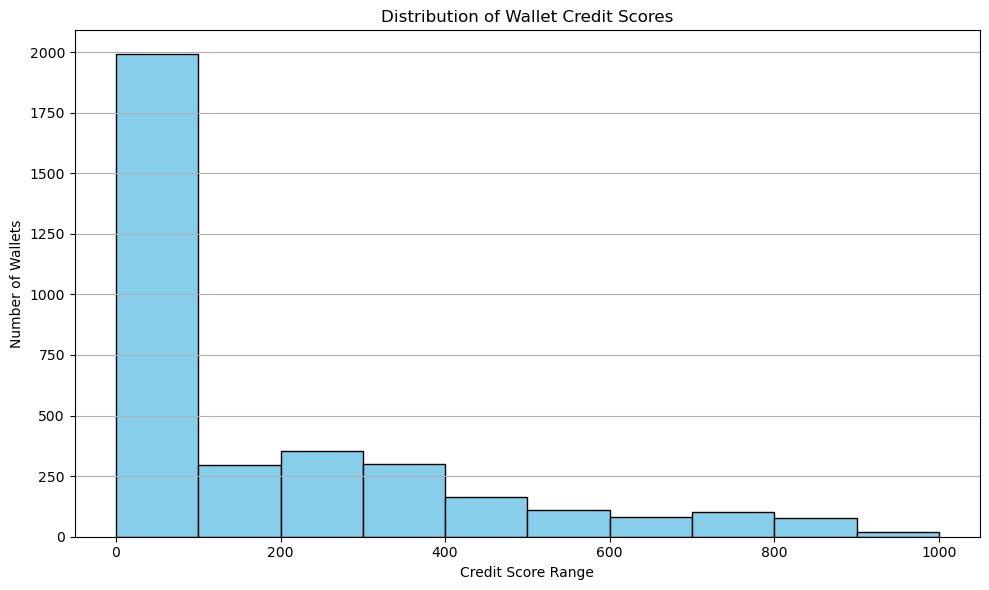

In [13]:
import matplotlib.pyplot as plt

# Plotting the credit score distribution
plt.figure(figsize=(10, 6))
plt.hist(features_df["credit_score"], bins=10, edgecolor='black', color='skyblue')
plt.xlabel("Credit Score Range")
plt.ylabel("Number of Wallets")
plt.title("Distribution of Wallet Credit Scores")
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("wallet_score_distribution.png")
plt.show()
